In [1]:
import warnings
warnings.filterwarnings('ignore')

Task description 
----------------
The file task_data.csv contains an example data set that has been artificially
generated. The set consists of 400 samples where for each sample there are 10
different sensor readings available. The samples have been divided into two
classes where the class label is either 1 or -1. The class labels define to what
particular class a particular sample belongs.

Your task is to rank the sensors according to their importance/predictive power
with respect to the class labels of the samples. Your solution should be a
Python script or a Jupyter notebook file that generates a ranking of the sensors
from the provided CSV file. The ranking should be in decreasing order where the
first sensor is the most important one.

Hint: There are many reasonable solutions to our task.
We are looking for good, insightful ones that are the least arbitrary. Please
beware of the quality of the code as well.

## Approach

This can be interpreted as a derivative of feature selection problem. There are a ton of methods in literature but ultimately the closest to optimal solution depends on the quantity and quality of the data.
   There are basically 3 categories of feature selection methods
   -  __Filter Methods__
   -  __Wrapper__ 
   -  __Embedded Methods__ - (regularization) Normally used for regression techniques
     
Since the problem is to rank the sensors/features. An ideal approach to start with can be a univariate solution like ___pearson correlation___. But 1st let’s do an exploratory analysis on the data.<span>

### <span style="color:brown"> Note1: To check the result you can directly skip to the "Summary" Section <span>
### <span style="color:green"> Note2: My comments and observations have been highlighted  in green <span>

##  1.Exploratory Data Analysis<span>
### 1.1 Import data and libraries 

In [2]:
import pandas as pd
import numpy as np
data=pd.read_csv("task_data.csv")
data=data.set_index('sample index')
data.shape

(400, 11)

### <span style="color:green">Cheking if sampling is required

### 1.2 Display data attribute information and dataset statistics

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, sample0 to sample399
Data columns (total 11 columns):
class_label    400 non-null float64
sensor0        400 non-null float64
sensor1        400 non-null float64
sensor2        400 non-null float64
sensor3        400 non-null float64
sensor4        400 non-null float64
sensor5        400 non-null float64
sensor6        400 non-null float64
sensor7        400 non-null float64
sensor8        400 non-null float64
sensor9        400 non-null float64
dtypes: float64(11)
memory usage: 37.5+ KB


,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


### 1.3 Frequency and number of class labels

In [4]:
data.groupby("class_label").count()

,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
class_label,,,,,,,,,,
-1.0,200,200,200,200,200,200,200,200,200,200
1.0,200,200,200,200,200,200,200,200,200,200


### <span style="color:green"> Since data is only 400 rows and 10 columns there is no need for sampling of the dataset <span>

### 1.4 Visualize distribution of features using __Box plot__ and __Violin plots__

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

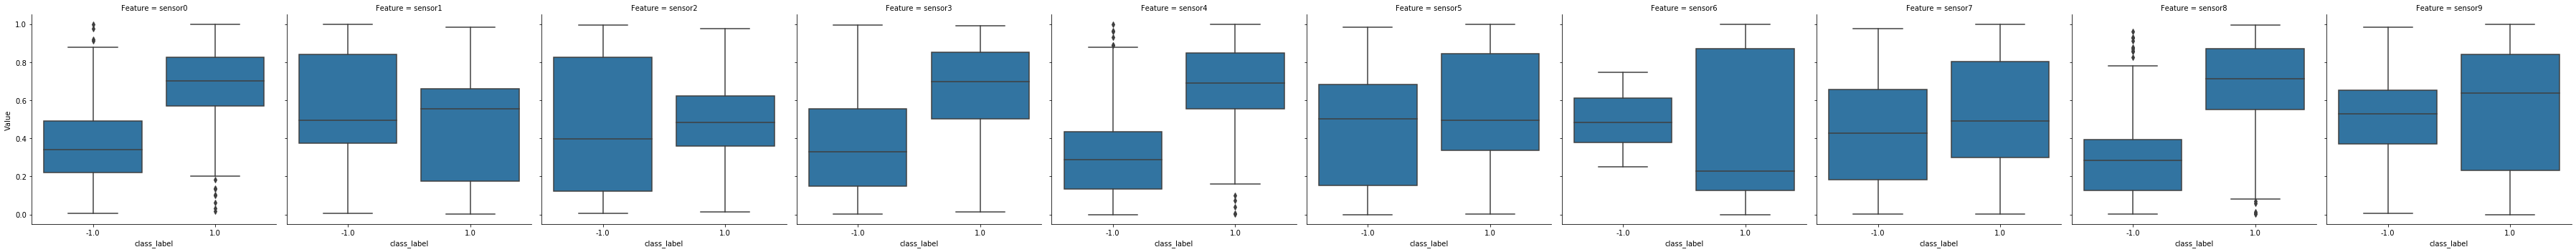

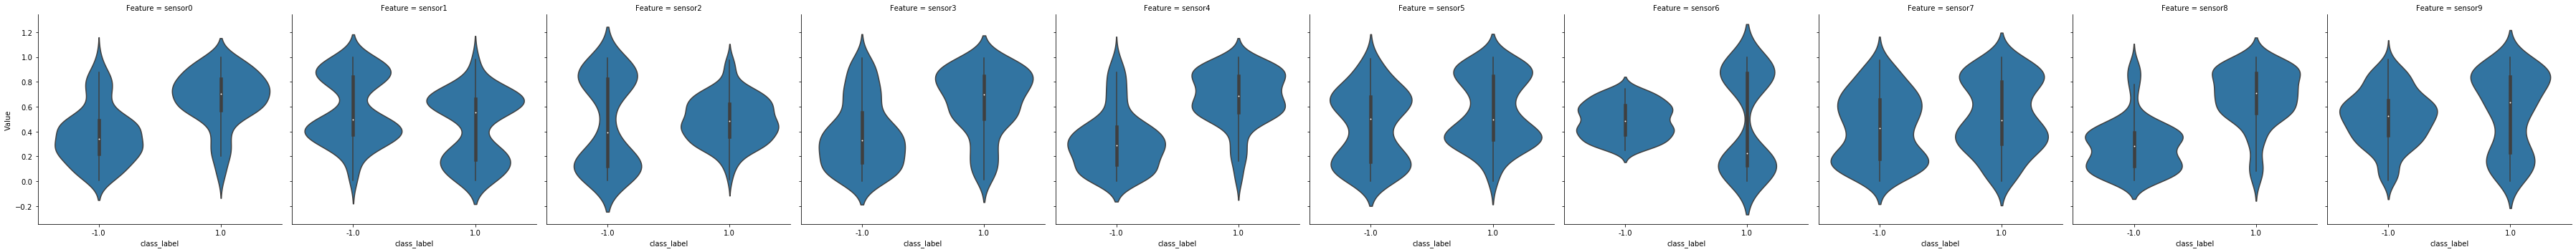

In [6]:
df_temp = pd.melt(data,id_vars='class_label',value_vars=list(data.columns)[1:], var_name="Feature", value_name="Value")
g = sns.FacetGrid(data = df_temp, col="Feature", col_wrap=10, height=5,sharey = True)
g.map(sns.boxplot,"class_label", "Value");
g = sns.FacetGrid(data = df_temp, col="Feature", col_wrap=10, height=5,sharey = True)
g.map(sns.violinplot,"class_label", "Value");

### <span style="color:green"> Almost all the features are unevenly distributed, central tendancy has been shifted away. Outliers incase of sensor 0, 4 and 7

### 1.5 Visualizations of Pairwise distributions and Scatter of features

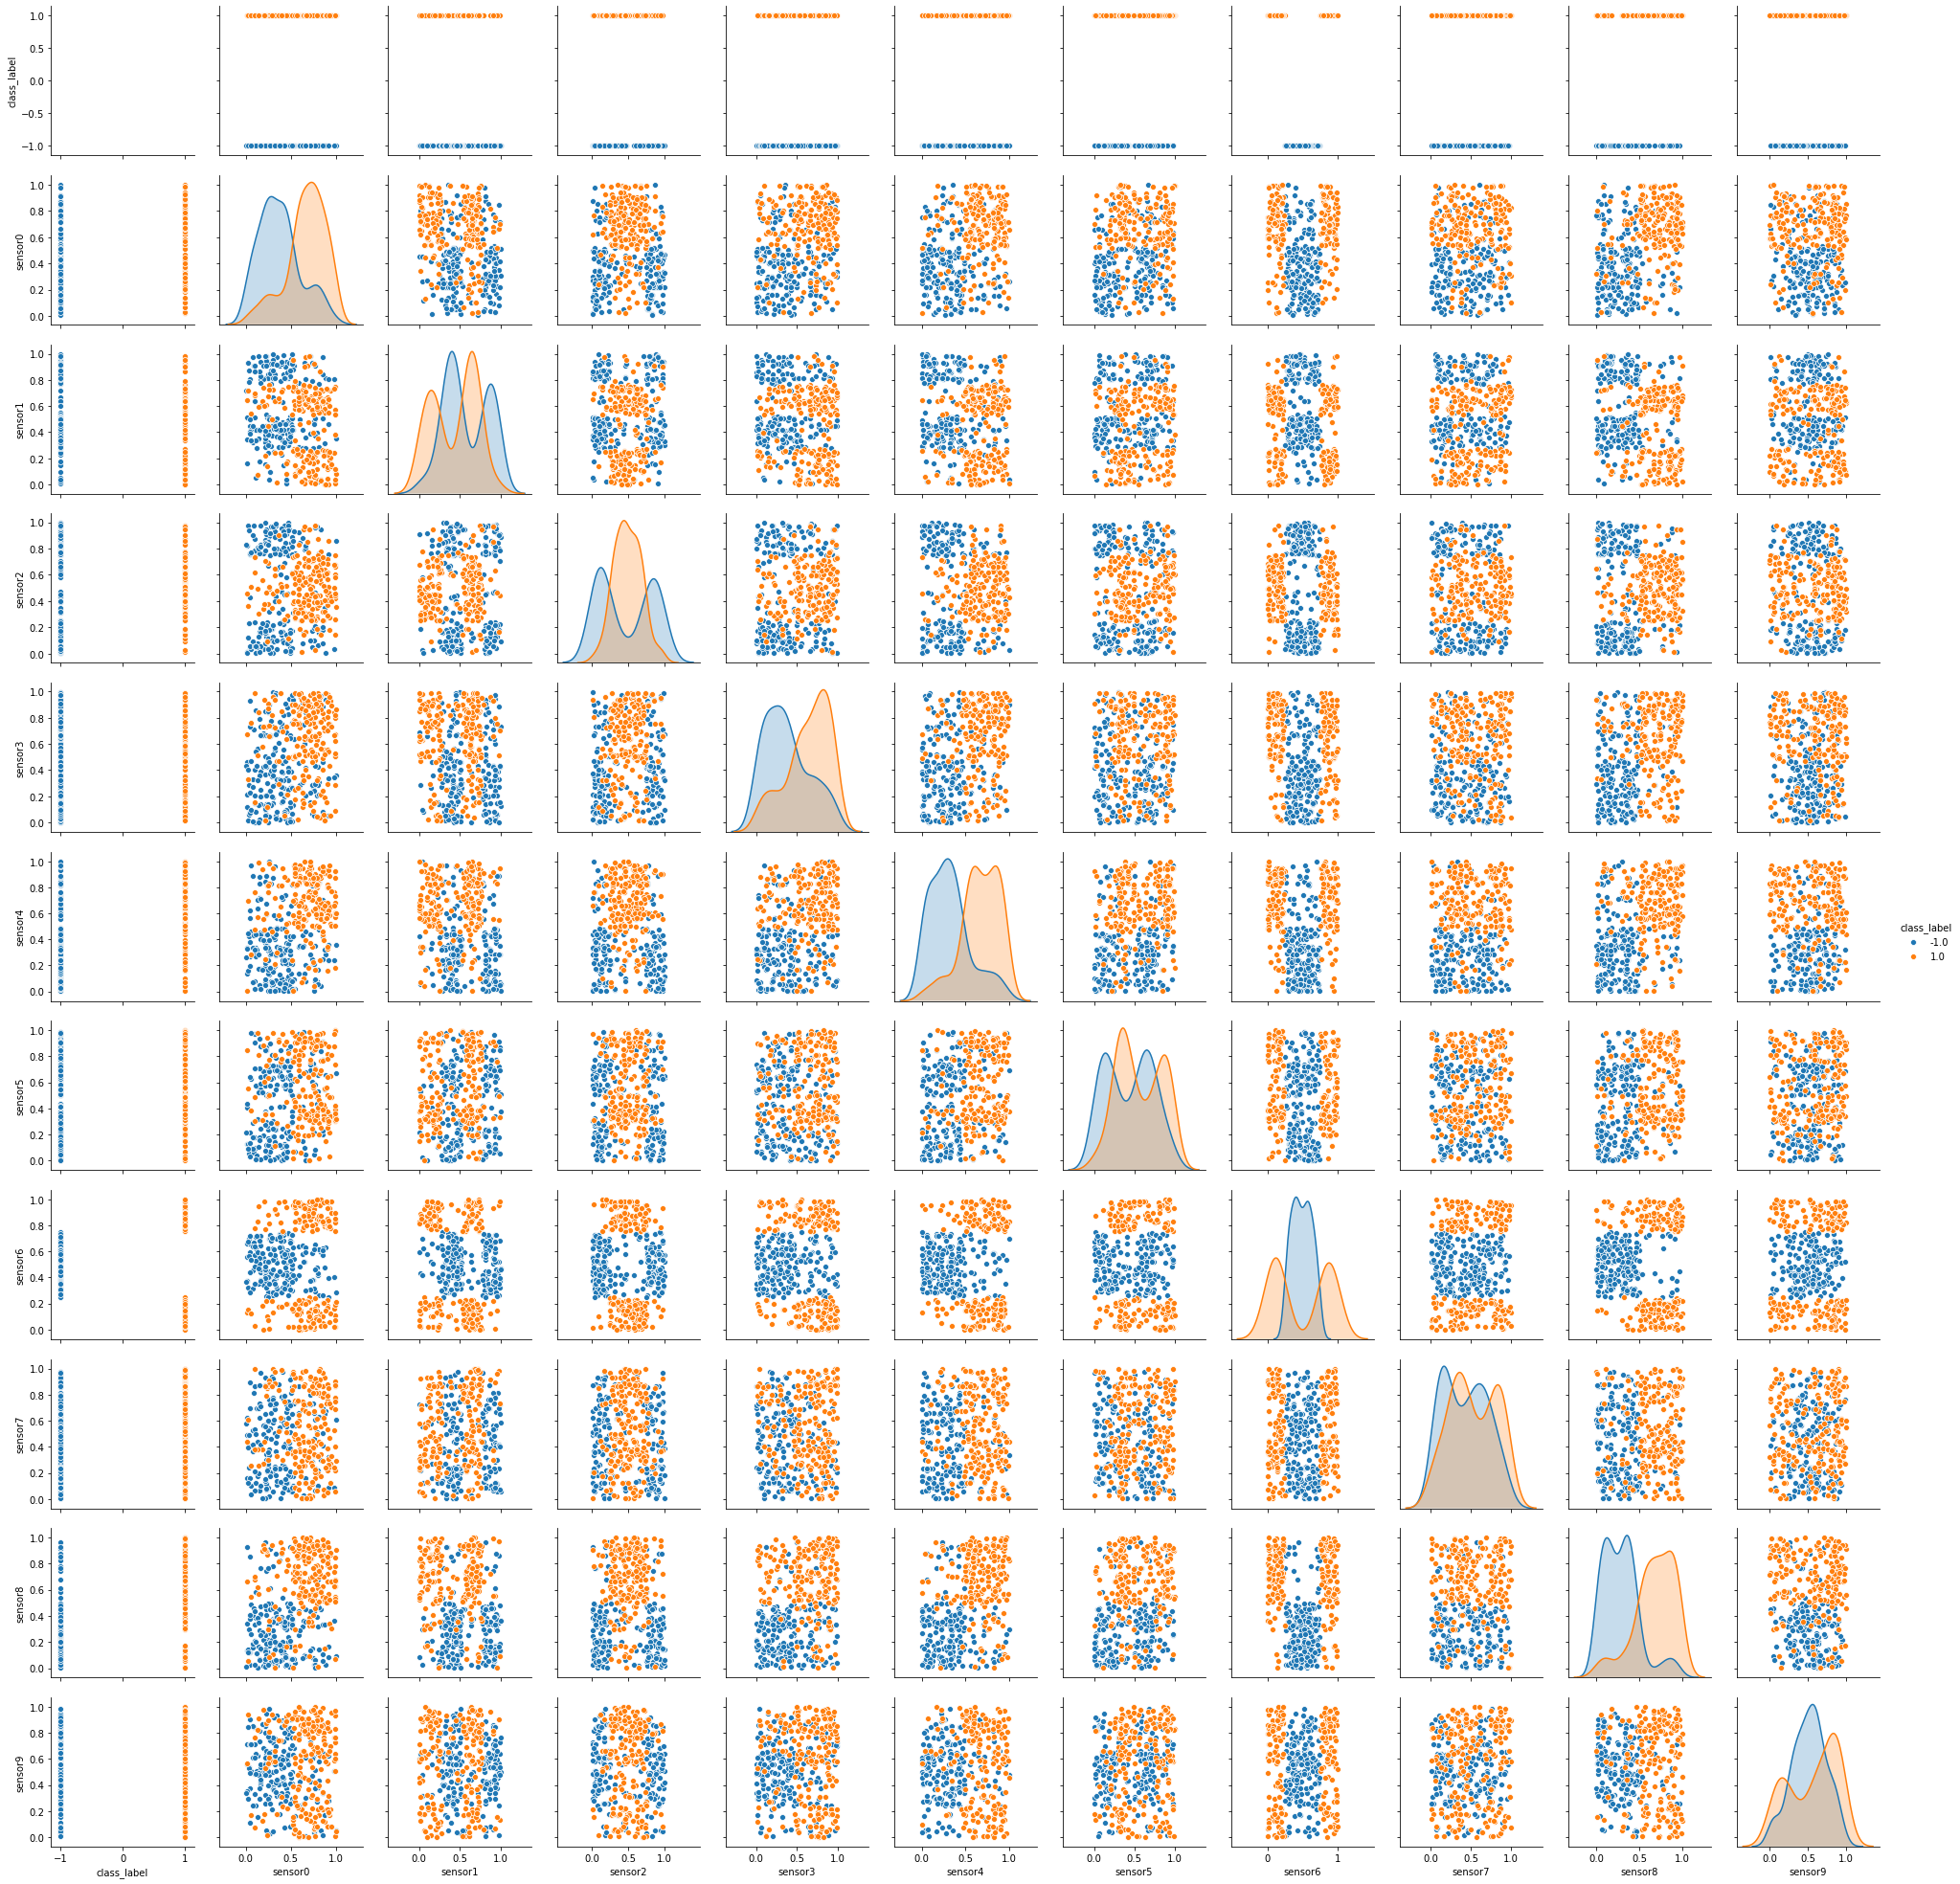

In [7]:
sns.pairplot(data,hue="class_label")

### <span style="color:green"> Most of the distributions of features have two peaks and nowhere close to being distributed uniformly.
### <span style="color:green"> Interestingly we can see a pattern with the scatter plot of _"SENSOR6"_ which has a clear distinction of separation in the data points with respect to labels.
### <span style="color:green">Since data has multiple peaks, let’s see if the "Logarithmic Transform" of data also show's multiple peaks<span>

### 1.6 Logarithmic Transform of Data

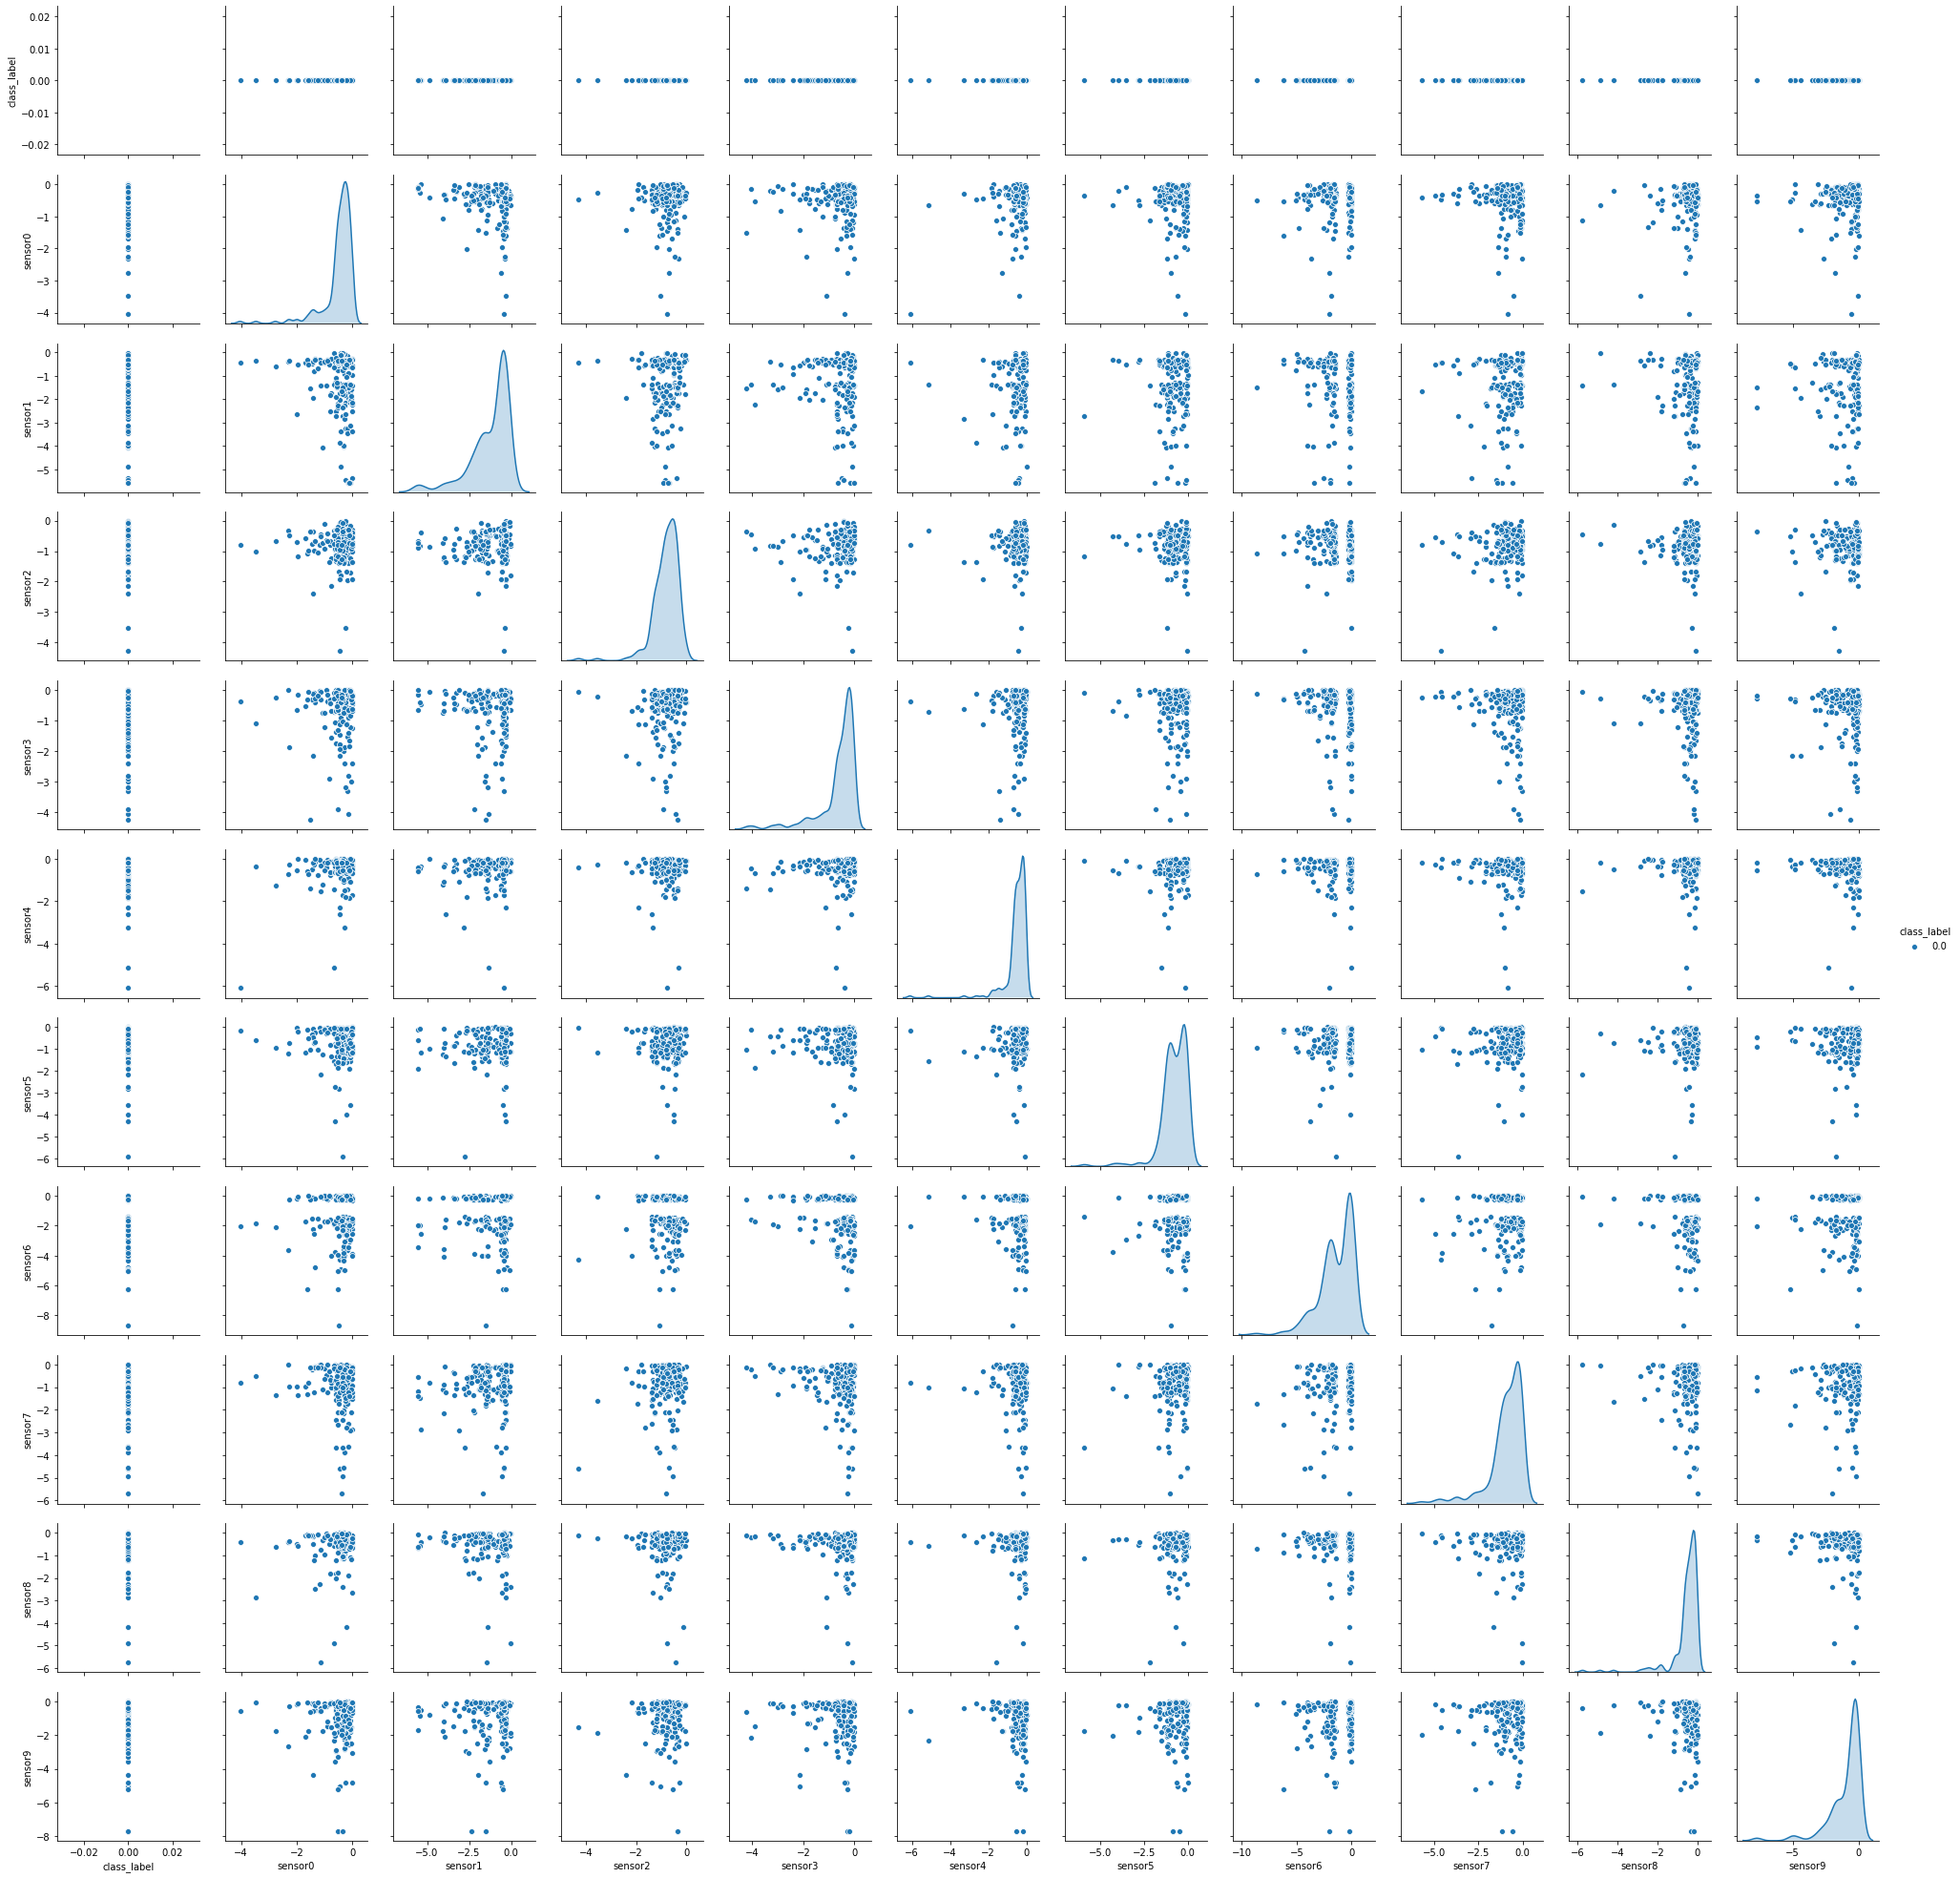

In [8]:
sns.pairplot(np.log(data),hue="class_label")

### <span style="color:green"> Multiple peaks have been reduced with the log transform of the data, but data is still skewed to the right

### 1.7 ROC curve of features - 1st look at important of features

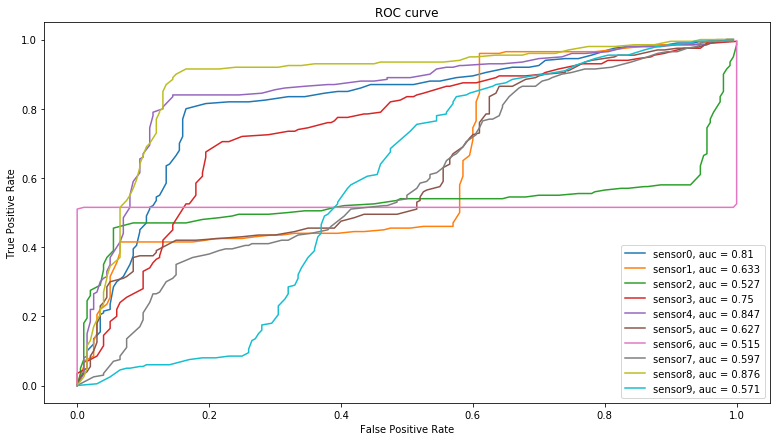

In [9]:
from sklearn.metrics import accuracy_score , roc_auc_score, auc, confusion_matrix, mutual_info_score
y_ = data.class_label == -1
plt.figure(figsize=(13,7))
for col in range(1,data.shape[1]):
    tpr,fpr = [],[]
    for threshold in np.linspace(min(data.iloc[:,col]),max(data.iloc[:,col]),100):
        detP = data.iloc[:,col] < threshold
        tpr.append(sum(detP & y_)/sum(y_))# TP/P, aka recall
        fpr.append(sum(detP & (~y_))/sum((~y_)))# FP/N
        
    if auc(fpr,tpr) < .5:
        aux = tpr
        tpr = fpr
        fpr = aux
    plt.plot(fpr,tpr,label=data.columns[col] + ', auc = '\
                           + str(np.round(auc(fpr,tpr),decimals=3)))
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### <span style="color:green"> Inference from visualisation we can see sensors 8, 4, 0 could be important for prediction as the areas enclosed under the curve are on the higher side

##  2 Filter Methods
### <span style="color:green"> Statistical inference of features without any training algorithm

### 2.1 Correlation
#### 2.1.1 Pearson

### <span style="color:green">Normally highly correlated features are discarded in feature selection but here we are checking for features correlated with class labels as these can form a linear relationship, hence we are looking for high absolute values for correlation coefficients

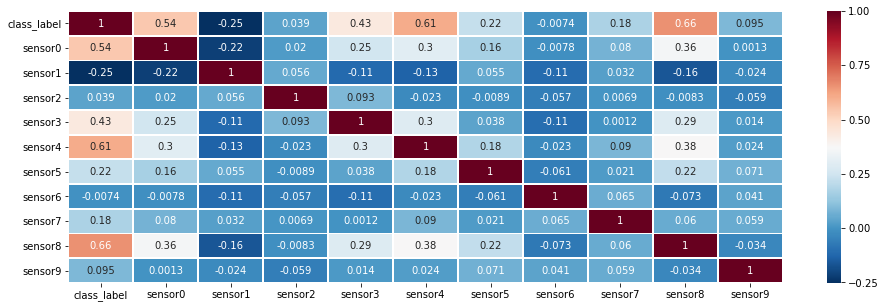

[('sensor8', 0.661),
 ('sensor4', 0.608),
 ('sensor0', 0.543),
 ('sensor3', 0.434),
 ('sensor1', 0.252),
 ('sensor5', 0.224),
 ('sensor7', 0.176),
 ('sensor9', 0.095),
 ('sensor2', 0.039),
 ('sensor6', 0.007)]

In [10]:
result={}
cols=data.columns[1:]

pearsoncorr=data.corr(method='pearson')

plt.figure(figsize=(16,5))
b, t = plt.ylim() 
b += 0.5 # Add 0.5 to the bottom
t += 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.9)
plt.show()

temp=list(abs(pearsoncorr.class_label[1:]))
indices = np.argsort(temp)[::-1]
temp.sort(reverse=True)
result['Pearson']=list(zip(cols[indices], np.around(temp,3)))
display(result['Pearson'])


#### 2.1.2 Spearman

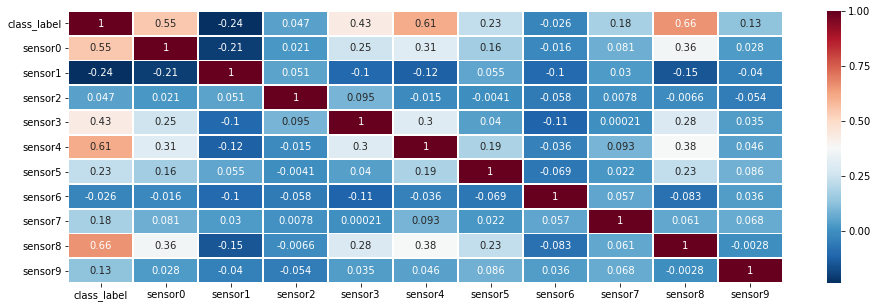

[('sensor8', 0.661),
 ('sensor4', 0.608),
 ('sensor0', 0.543),
 ('sensor3', 0.434),
 ('sensor1', 0.252),
 ('sensor5', 0.224),
 ('sensor7', 0.176),
 ('sensor9', 0.095),
 ('sensor2', 0.039),
 ('sensor6', 0.007)]

In [11]:
spearmancorr=data.corr(method='spearman')

plt.figure(figsize=(16,5))
b, t = plt.ylim() 
b += 0.5 # Add 0.5 to the bottom
t += 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
sns.heatmap(spearmancorr, 
            xticklabels=spearmancorr.columns,
            yticklabels=spearmancorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.9)

temp=list(abs(pearsoncorr.class_label[1:]))
indices = np.argsort(temp)[::-1]
temp.sort(reverse=True)

plt.show()
result['Spearman']=list(zip(cols[indices], np.around(temp,3)))
display(result['Spearman'])

### 2.2 Mutual Information between class and features

In [12]:
from sklearn.feature_selection import mutual_info_classif

features=data.iloc[:,1:]
labels=data.class_label

importance_vals=mutual_info_classif(features.to_numpy(),labels.to_numpy())
indices = np.argsort(importance_vals)[::-1]

result['Mutual_Info']=list(zip(cols[indices], np.around(importance_vals[indices],3)))
display(result['Mutual_Info'])

[('sensor6', 0.686),
 ('sensor1', 0.37),
 ('sensor8', 0.325),
 ('sensor2', 0.302),
 ('sensor4', 0.249),
 ('sensor0', 0.195),
 ('sensor5', 0.157),
 ('sensor3', 0.092),
 ('sensor9', 0.083),
 ('sensor7', 0.0)]

### 2.3 Eigen value sorting 
### <span style="color:green">My Hypothesis: since principle compnent vectors are created by reconstruction eigen vectors in decreasing order of eigen values, i am using the same logic to find corresponding features.

In [13]:
from sklearn import preprocessing

x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

from numpy import linalg as la
evals,evecs = la.eig(df.cov())

indices = np.argsort(evals)[::-1]
result['Eigen_Value_Sort']=(list(zip(cols[indices],np.around(evals[indices],3))))
result['Eigen_Value_Sort']

[('sensor0', 0.177),
 ('sensor1', 0.1),
 ('sensor6', 0.091),
 ('sensor7', 0.085),
 ('sensor8', 0.075),
 ('sensor9', 0.073),
 ('sensor5', 0.065),
 ('sensor4', 0.054),
 ('sensor3', 0.052),
 ('sensor2', 0.049)]

### <span style="color:green">Seems like the sorting is nowhere close to other methods. Reasons for this can be PCA is a lossy transformation and eigenvalues may not be ranking the features rather ranking the principal components.

### 2.4 Chi-Squared statistical test

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# Feature extraction
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(features, labels)

indices = fit.scores_.argsort()[::-1]
result['Chi_Squared']=list(zip(cols[indices], np.around(fit.scores_[indices],3)))
display(result['Chi_Squared'])

[('sensor8', 31.637),
 ('sensor4', 24.577),
 ('sensor0', 16.177),
 ('sensor3', 13.045),
 ('sensor1', 3.815),
 ('sensor5', 3.31),
 ('sensor7', 2.039),
 ('sensor9', 0.492),
 ('sensor2', 0.103),
 ('sensor6', 0.004)]

## 3 Wrapper Methods <span>

#### 3.1 Sequential Feature Selection

In [15]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import SequentialFeatureSelector as sfs, ExhaustiveFeatureSelector as efs

import pickle

In [16]:
train_features, test_features, train_labels, test_labels = train_test_split(
    data.drop(labels=['class_label'], axis=1),
    data['class_label'],
    test_size=0.2,
    random_state=41)

In [17]:
rf=RandomForestClassifier(n_jobs=-1)

s_feature_selector = sfs(rf,
           k_features=10,
           forward=True,
           verbose=2,
           scoring='roc_auc',
           cv=4)

e_feature_selector = efs(rf, 
           min_features=1,
           max_features=1,
           scoring='roc_auc',
           print_progress=True,
           cv=5)
 

In [18]:
option = 'N'#input("Type \"N\": to train the model or \n\"Y\"(faster): to load trained model")
if option=='N':
    sfs_features = s_feature_selector.fit(features, labels)
    #pickle.dump(sfs_features, open(filename, 'wb'))
else:
    filename = 'sfs_features.sav'
    sfs_features = pickle.load(open(filename, 'rb'))

Type "N": to train the model or 
"Y"(faster): to load trained modelY


In [19]:
df1 = pd.DataFrame.from_dict(sfs_features.get_metric_dict()).T
df1.sort_values('feature_idx', inplace=True, ascending=False)
df1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
2,"(6, 9)","[1.0, 0.9994, 1.0, 0.9985999999999999]",0.9995,"(sensor6, sensor9)",0.000920843,0.000574456,0.000331662
1,"(6,)","[1.0, 0.99, 1.0, 1.0]",0.9975,"(sensor6,)",0.00694111,0.00433013,0.0025
3,"(1, 6, 9)","[0.9950000000000001, 1.0, 1.0, 0.9994000000000...",0.9986,"(sensor1, sensor6, sensor9)",0.00335479,0.00209284,0.0012083
4,"(0, 1, 6, 9)","[0.9999999999999999, 1.0, 1.0, 1.0]",1,"(sensor0, sensor1, sensor6, sensor9)",8.89833e-17,5.55112e-17,3.20494e-17
5,"(0, 1, 6, 7, 9)","[1.0, 1.0, 1.0, 0.9990000000000001]",0.99975,"(sensor0, sensor1, sensor6, sensor7, sensor9)",0.000694111,0.000433013,0.00025
6,"(0, 1, 5, 6, 7, 9)","[0.9998, 0.9992, 1.0, 0.9996]",0.99965,"(sensor0, sensor1, sensor5, sensor6, sensor7, ...",0.000474168,0.000295804,0.000170783
7,"(0, 1, 2, 5, 6, 7, 9)","[0.9994000000000001, 0.9989999999999999, 1.0, ...",0.99895,"(sensor0, sensor1, sensor2, sensor5, sensor6, ...",0.00154378,0.000963068,0.000556028
8,"(0, 1, 2, 3, 5, 6, 7, 9)","[0.9958, 0.9962, 0.9998, 0.998]",0.99745,"(sensor0, sensor1, sensor2, sensor3, sensor5, ...",0.00254844,0.00158981,0.000917878
9,"(0, 1, 2, 3, 5, 6, 7, 8, 9)","[1.0, 1.0, 0.9956, 0.9996]",0.9988,"(sensor0, sensor1, sensor2, sensor3, sensor5, ...",0.00297309,0.00185472,0.00107083
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[1.0, 0.9954000000000001, 1.0, 0.9998]",0.9988,"(sensor0, sensor1, sensor2, sensor3, sensor4, ...",0.00314936,0.00196469,0.00113431


In [20]:
lst=[]
for _, item in sfs_features.get_metric_dict().items():
    for tup in item.get('feature_names'):
        if tup not in lst:
            lst.append(tup)
            
result['Sequential_Selection']=list(zip(lst,range(1,11)))
display(result['Sequential_Selection'])

[('sensor6', 1),
 ('sensor9', 2),
 ('sensor1', 3),
 ('sensor0', 4),
 ('sensor7', 5),
 ('sensor5', 6),
 ('sensor2', 7),
 ('sensor3', 8),
 ('sensor8', 9),
 ('sensor4', 10)]

### <span style="color:green">Sequentially selecting features based on RF classifier using area under the curve of ROC

### 3.2 Exhaustive Feature Selection

In [21]:
if option=='N':
    efs_features = e_feature_selector.fit(features, labels)
    #pickle.dump(efs_features, open(filename, 'wb'))
else:
    filename = 'efs_features.sav'
    efs_features = pickle.load(open(filename, 'rb'))

In [22]:
efs_features = pickle.load(open(filename, 'rb'))

In [23]:
df1 = pd.DataFrame.from_dict(efs_features.get_metric_dict()).T
df1.sort_values('avg_score', inplace=True, ascending=False)
df1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
6,"(6,)","[1.0, 1.0, 1.0, 1.0, 1.0]",1,"(sensor6,)",0,0,0
1,"(1,)","[0.8968750000000001, 0.8574999999999999, 0.837...",0.8655,"(sensor1,)",0.0254809,0.019825,0.00991251
8,"(8,)","[0.849375, 0.8250000000000001, 0.8140625, 0.85...",0.852375,"(sensor8,)",0.0461343,0.035894,0.017947
2,"(2,)","[0.82375, 0.836875, 0.883125, 0.7884375, 0.760...",0.818625,"(sensor2,)",0.0537943,0.0418538,0.0209269
4,"(4,)","[0.76875, 0.81, 0.82625, 0.7671875, 0.77125]",0.788687,"(sensor4,)",0.0316348,0.0246129,0.0123065
0,"(0,)","[0.5825, 0.7943749999999999, 0.7453125, 0.7659...",0.728437,"(sensor0,)",0.0961706,0.074824,0.037412
5,"(5,)","[0.664375, 0.76125, 0.6253124999999999, 0.6703...",0.694813,"(sensor5,)",0.068338,0.0531693,0.0265847
3,"(3,)","[0.5162500000000001, 0.609375, 0.6196875000000...",0.623313,"(sensor3,)",0.100382,0.0781009,0.0390504
9,"(9,)","[0.654375, 0.58, 0.6128125000000001, 0.59625, ...",0.614062,"(sensor9,)",0.032861,0.025567,0.0127835
7,"(7,)","[0.59375, 0.4940625, 0.5903125, 0.5925, 0.5190...",0.557937,"(sensor7,)",0.0548821,0.0427002,0.0213501


In [24]:
names=np.asarray([efs_features.get_metric_dict().get(i).get('feature_names')[0] for i in range(10)])
scores=np.asarray([efs_features.get_metric_dict().get(i).get('avg_score') for i in range(10)])
indices = np.argsort(scores)[::-1]
result['Exhaustive_Selection']=list(zip(names[indices],np.around(scores[indices],3)))
display(result['Exhaustive_Selection'])


[('sensor6', 1.0),
 ('sensor1', 0.865),
 ('sensor8', 0.852),
 ('sensor2', 0.819),
 ('sensor4', 0.789),
 ('sensor0', 0.728),
 ('sensor5', 0.695),
 ('sensor3', 0.623),
 ('sensor9', 0.614),
 ('sensor7', 0.558)]

### <span style="color:green">Exhaustively checking one feature at a time based on RF classifier using area under the curve of ROC

### 3.3 Feature Importance from a classifier and Feature Permutation Importance
### <span style="color:green">Ranking features using classifiers methods. Also post that checking the feature importance by randomy values in the data.
   #### XGBoost, Random Forest, Decision Tree, Support Vector Machine

In [25]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [26]:
classifiers=[]
model1 = RandomForestClassifier()
classifiers.append(model1)
model2 = SVC(kernel='linear')
classifiers.append(model2)
model3 = DecisionTreeClassifier()
classifiers.append(model3)
model4 = XGBClassifier()
classifiers.append(model4)

Accuracy of RandomForestClassifier is: 0.9875

Confusion Matrix:
[[36  1]
 [ 0 43]]

Feature Score of RandomForestClassifier:


[('sensor6', 0.36),
 ('sensor4', 0.209),
 ('sensor0', 0.18),
 ('sensor8', 0.109),
 ('sensor2', 0.051),
 ('sensor1', 0.04),
 ('sensor3', 0.02),
 ('sensor9', 0.017),
 ('sensor5', 0.01),
 ('sensor7', 0.005)]

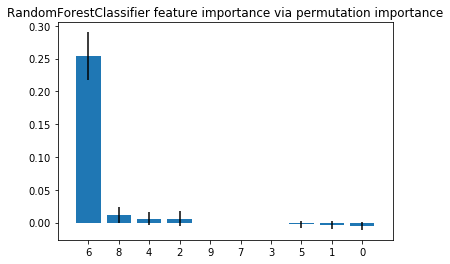

Accuracy of SVC is: 0.8875

Confusion Matrix:
[[30  7]
 [ 2 41]]

Feature Score of SVC:


[('sensor8', 2.81),
 ('sensor4', 2.608),
 ('sensor0', 2.182),
 ('sensor3', 1.342),
 ('sensor9', 0.784),
 ('sensor5', 0.665),
 ('sensor7', 0.606),
 ('sensor6', 0.523),
 ('sensor2', 0.141),
 ('sensor1', -0.996)]

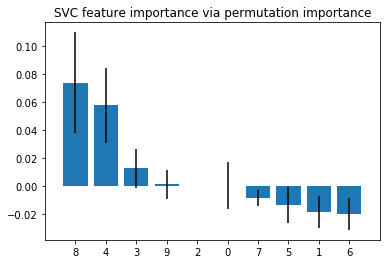

Accuracy of DecisionTreeClassifier is: 0.9875

Confusion Matrix:
[[36  1]
 [ 0 43]]

Feature Score of DecisionTreeClassifier:


[('sensor8', 0.556),
 ('sensor6', 0.369),
 ('sensor0', 0.052),
 ('sensor1', 0.012),
 ('sensor4', 0.01),
 ('sensor9', 0.0),
 ('sensor7', 0.0),
 ('sensor5', 0.0),
 ('sensor3', 0.0),
 ('sensor2', 0.0)]

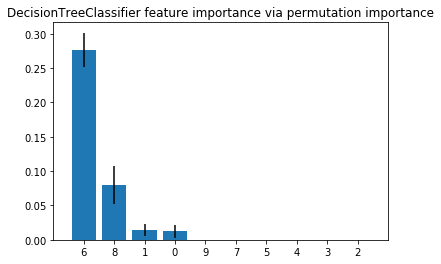

Accuracy of XGBClassifier is: 1.0

Confusion Matrix:
[[37  0]
 [ 0 43]]

Feature Score of XGBClassifier:


[('sensor8', 0.519),
 ('sensor6', 0.138),
 ('sensor7', 0.076),
 ('sensor4', 0.074),
 ('sensor0', 0.056),
 ('sensor5', 0.044),
 ('sensor1', 0.039),
 ('sensor9', 0.032),
 ('sensor2', 0.02),
 ('sensor3', 0.003)]

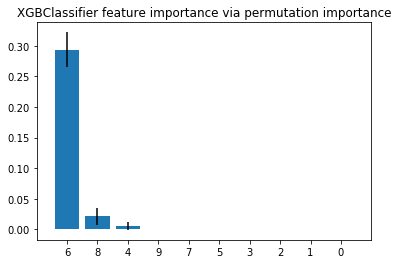

In [27]:
for clf in classifiers:
    clf.fit(train_features.to_numpy(), train_labels.to_numpy() )
    y_pred= clf.predict(test_features.to_numpy())
    acc = accuracy_score(test_labels, y_pred)
    print("Accuracy of %s is: %s\n"%(clf.__class__.__name__, acc))
    cm = confusion_matrix(test_labels, y_pred)
    print("Confusion Matrix:\n%s"%( cm))    
    
    # Plot the feature importances of the forest
    imp_vals, imp_all = feature_importance_permutation(
        predict_method=clf.predict, 
        X=test_features.to_numpy(),
        y=test_labels.to_numpy(),
        metric='accuracy',
        num_rounds=10,
        seed=1)
    
    if clf==model2:
        indices=np.argsort(clf.coef_.ravel())[::-1]
        result[clf.__class__.__name__]=list(zip(cols[indices.ravel()], np.around(clf.coef_.ravel()[indices.ravel()],3))) 
    else:
        indices=np.argsort(clf.feature_importances_)[::-1]
        result[clf.__class__.__name__]=list(zip(cols[indices], np.around(clf.feature_importances_[indices],3)))

    print("\nFeature Score of %s:"%(clf.__class__.__name__))
    display(result[clf.__class__.__name__])
    
    std = np.std(imp_all, axis=1)
    indices = np.argsort(imp_vals)[::-1]
    #result[clf.__class__.__name__]=list(zip(cols[indices], np.around(imp_vals[indices],3)))
        
    plt.figure()
    plt.title("%s feature importance via permutation importance"%(clf.__class__.__name__))
    plt.bar(range(test_features.shape[1]), imp_vals[indices],
            yerr=std[indices])
    plt.xticks(range(test_features.shape[1]), indices)
    plt.xlim([-1, test_features.shape[1]])
    plt.show()
    

### 4 Summary

### <span style="color:green">Results table displayed below with respect to method used in rows and raking of sensors based on left to right

In [28]:
df1 = pd.DataFrame.from_dict(result).T
df1

,0,1,2,3,4,5,6,7,8,9
Pearson,"(sensor8, 0.661)","(sensor4, 0.608)","(sensor0, 0.543)","(sensor3, 0.434)","(sensor1, 0.252)","(sensor5, 0.224)","(sensor7, 0.176)","(sensor9, 0.095)","(sensor2, 0.039)","(sensor6, 0.007)"
Spearman,"(sensor8, 0.661)","(sensor4, 0.608)","(sensor0, 0.543)","(sensor3, 0.434)","(sensor1, 0.252)","(sensor5, 0.224)","(sensor7, 0.176)","(sensor9, 0.095)","(sensor2, 0.039)","(sensor6, 0.007)"
Mutual_Info,"(sensor6, 0.686)","(sensor1, 0.37)","(sensor8, 0.325)","(sensor2, 0.302)","(sensor4, 0.249)","(sensor0, 0.195)","(sensor5, 0.157)","(sensor3, 0.092)","(sensor9, 0.083)","(sensor7, 0.0)"
Eigen_Value_Sort,"(sensor0, 0.177)","(sensor1, 0.1)","(sensor6, 0.091)","(sensor7, 0.085)","(sensor8, 0.075)","(sensor9, 0.073)","(sensor5, 0.065)","(sensor4, 0.054)","(sensor3, 0.052)","(sensor2, 0.049)"
Chi_Squared,"(sensor8, 31.637)","(sensor4, 24.577)","(sensor0, 16.177)","(sensor3, 13.045)","(sensor1, 3.815)","(sensor5, 3.31)","(sensor7, 2.039)","(sensor9, 0.492)","(sensor2, 0.103)","(sensor6, 0.004)"
Sequential_Selection,"(sensor6, 1)","(sensor9, 2)","(sensor1, 3)","(sensor0, 4)","(sensor7, 5)","(sensor5, 6)","(sensor2, 7)","(sensor3, 8)","(sensor8, 9)","(sensor4, 10)"
Exhaustive_Selection,"(sensor6, 1.0)","(sensor1, 0.865)","(sensor8, 0.852)","(sensor2, 0.819)","(sensor4, 0.789)","(sensor0, 0.728)","(sensor5, 0.695)","(sensor3, 0.623)","(sensor9, 0.614)","(sensor7, 0.558)"
RandomForestClassifier,"(sensor6, 0.36)","(sensor4, 0.209)","(sensor0, 0.18)","(sensor8, 0.109)","(sensor2, 0.051)","(sensor1, 0.04)","(sensor3, 0.02)","(sensor9, 0.017)","(sensor5, 0.01)","(sensor7, 0.005)"
SVC,"(sensor8, 2.81)","(sensor4, 2.608)","(sensor0, 2.182)","(sensor3, 1.342)","(sensor9, 0.784)","(sensor5, 0.665)","(sensor7, 0.606)","(sensor6, 0.523)","(sensor2, 0.141)","(sensor1, -0.996)"
DecisionTreeClassifier,"(sensor8, 0.556)","(sensor6, 0.369)","(sensor0, 0.052)","(sensor1, 0.012)","(sensor4, 0.01)","(sensor9, 0.0)","(sensor7, 0.0)","(sensor5, 0.0)","(sensor3, 0.0)","(sensor2, 0.0)"


##  5 conclusion and Result
### <span style="color:brown"> I conclude using scores from __XGBoost Classifier__ Feature Importance Method since feature importances is essentially the mean of the individual trees’ improvement in the splitting criterion produced by each feature.

 -  ### <span style="color:brown">Strengths: classification accuracy is highest among all metrics that could be validated
 -  ### <span style="color:brown">Weaknesses: Feature Importance Methods suffers from biases and, and presents an unexpected behaviour regarding highly correlated features. 
 -  ### <span style="color:brown">Scalability: Although XGboost is a parallelized and optimized algorithm there is still problem as other classifiers are computationally expensive as the data increases. A workaround would be to use multiple subsets by sampling the data to perform a quick and dirty implementation before actual one.    
 -  ### <span style="color:brown">Alternate methods: Filter methods are faster as they don't rely on training complexity. Embedded methods are usually very efficient to avoid overfitting and select useful features. They are also time-efficient as they are embedded in the objective function. Their main downside is that they may not be available to the desired classifier

In [29]:
result['XGBClassifier']

[('sensor8', 0.519),
 ('sensor6', 0.138),
 ('sensor7', 0.076),
 ('sensor4', 0.074),
 ('sensor0', 0.056),
 ('sensor5', 0.044),
 ('sensor1', 0.039),
 ('sensor9', 0.032),
 ('sensor2', 0.02),
 ('sensor3', 0.003)]

## <span style="color:teal"> 6 References

Feature Importance Permutation:
http://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/
https://scikit-learn.org/dev/modules/permutation_importance.html
https://christophm.github.io/interpretable-ml-book/feature-importance.html#theory-3


Exhaustive feature selection
http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/

SEquential Feature selection
http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-1-a-simple-sequential-forward-selection-example